<a href="https://colab.research.google.com/github/dongjae-shin/Bayesian_opt_tutorial/blob/main/230221_1D_GPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 230223 Gaussian Process Regression (noise-less)

## 1. Sampling from prior

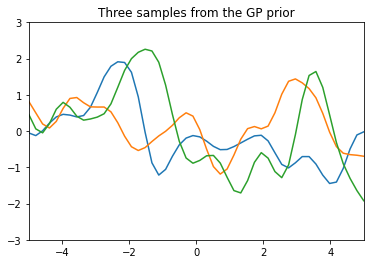

In [1]:
import numpy as np
import matplotlib.pyplot as pl

# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function; it seems to give covariance matrix, not each entry, by linear algebra
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    #"1st term:", np.sum(a**2,1).reshape(-1,1)|
    #"2nd term:", np.sum(b**2,1)              |<--- broadcasting trick
    #"3rd term:", - 2*np.dot(a, b.T)           <--- outer product
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.3
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3))) # np.dot can also do matrix multiplication

# Now let's plot the 3 sampled functions.
pl.plot(Xtest, f_prior)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP prior')
pl.show()

### studying in detail

* eye function test for the noise to kernel

In [2]:
# test of eye function
np.eye(N=5,M=7)

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]])

* broadcasting trick for summation of every combination   
third case was applied here.
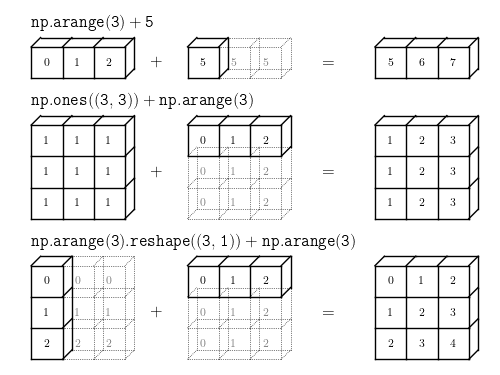


In [ ]:
A = np.linspace(-5, 5, 10).reshape(-1,1)
print("A:", A)
print("A**2:", A**2)
print("np.sum(A**2,1):", np.sum(A**2,1))
print("np.sum(A**2,1).reshape(-1,1):", np.sum(A**2,1).reshape(-1,1))
print("np.sum(A**2,1).reshape(-1,1) + np.sum(A**2,1):", np.sum(A**2,1).reshape(-1,1) + np.sum(A**2,1))

A: [[-5.        ]
 [-3.88888889]
 [-2.77777778]
 [-1.66666667]
 [-0.55555556]
 [ 0.55555556]
 [ 1.66666667]
 [ 2.77777778]
 [ 3.88888889]
 [ 5.        ]]
A**2: [[25.        ]
 [15.12345679]
 [ 7.71604938]
 [ 2.77777778]
 [ 0.30864198]
 [ 0.30864198]
 [ 2.77777778]
 [ 7.71604938]
 [15.12345679]
 [25.        ]]
np.sum(A**2,1): [25.         15.12345679  7.71604938  2.77777778  0.30864198  0.30864198
  2.77777778  7.71604938 15.12345679 25.        ]
np.sum(A**2,1).reshape(-1,1): [[25.        ]
 [15.12345679]
 [ 7.71604938]
 [ 2.77777778]
 [ 0.30864198]
 [ 0.30864198]
 [ 2.77777778]
 [ 7.71604938]
 [15.12345679]
 [25.        ]]
np.sum(A**2,1).reshape(-1,1) + np.sum(A**2,1): [[50.         40.12345679 32.71604938 27.77777778 25.30864198 25.30864198
  27.77777778 32.71604938 40.12345679 50.        ]
 [40.12345679 30.24691358 22.83950617 17.90123457 15.43209877 15.43209877
  17.90123457 22.83950617 30.24691358 40.12345679]
 [32.71604938 22.83950617 15.43209877 10.49382716  8.02469136  8.0246913

## 2. Sampling from posterior

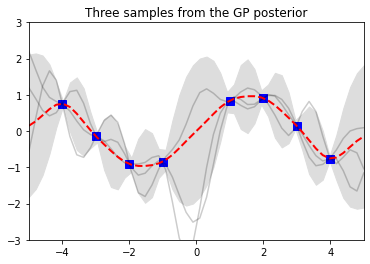

In [3]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1, 3,2,4]).reshape(-1,1)
ytrain = np.sin(Xtrain) # + np.random.normal() (size=(len(Xtrain),1))

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
v = np.linalg.solve(L, K_s)
mu = np.dot(v.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(v**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(v.T, v))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

pl.plot(Xtrain, ytrain, 'bs', ms=8)
pl.plot(Xtest, f_post, c='k', alpha=0.2)
pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP posterior')
pl.show()

## 3. Assuming noisy observations

$$y=f(x)+ϵ, \ where \ ϵ \sim \mathcal{N}(0,\sigma^2) $$  
It means we assume the observed (training) data include noise. In real application, I guess the observed value can be assumed to already include the noise, without explicitly giving noise as above.

$$K= (k(x_i,x_j))_{i,j\leq n}+\sigma^2*\mathbb{1}_n$$
$$K_*= (k(x_i,x_j))_{n+1\leq i, j\leq n}$$
$$K_{**}= (k(x_i,x_j))_{n+1\leq i,j}$$  
So, for the noise to the training data, we need to add noise covriance only to the training covariance matrix, $K$.  
(src: https://gitlab.com/youtube-optimization-geeks/uncertainty-quantification, section 15.2.2 of KPM book)



>  Q. How can adding noise to covariance values mean adding noise to observed 'function values'?  
* Even though the covariance function is the function of two input variables, $x_i$ and $x_j$, it means **the similarity of two function values at these two input variables, $f(x_i)$ and $f(x_j)$**. This is because we usually assume in GP that $f(x_i)$ and $f(x_j)$ are close together when $x_i$ and $x_j$ are close together. Namely, in fact, $\mathbb{cov}[f(x_j),f(x_j)]=κ(x_i,x_j)$  
(https://stats.stackexchange.com/questions/569601/why-is-the-covariance-function-of-a-gaussian-process-computed-for-the-inputs)  
* Therefore, adding diagonal matrix to the covariance matrix of training data (diagonal entries indicate the variance of the training data) means adding additional variance to that of observed **function values** in training data.

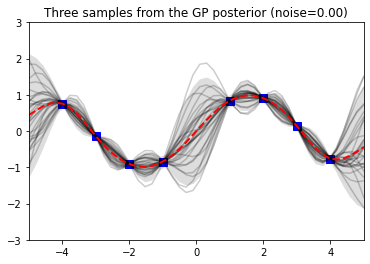

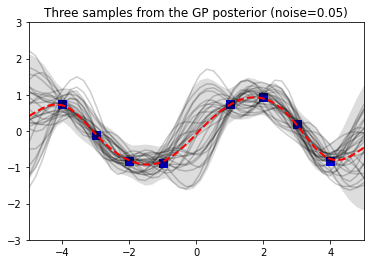

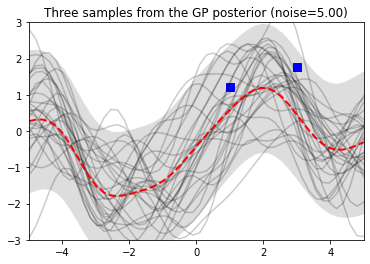

In [10]:
param = 0.7

for noise in [0.00, 0.05, 5.00]:
  K_ss = kernel(Xtest, Xtest, param)

  # Noiseless training data
  Xtrain = np.array([-4, -3, -2, -1, 1, 3,2,4]).reshape(-1,1)
  ytrain = np.sin(Xtrain) + noise * np.random.normal(size=(len(Xtrain),1))
                          # adding explicit noise to the observed values

  # Apply the kernel function to our training points
  K = kernel(Xtrain, Xtrain, param) \
      + noise * np.eye(N = len(Xtrain), M = len(Xtrain)) # add noise covariance to 
                                                         # training covariance matrix
  L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

  # Compute the mean at our test points.
  K_s = kernel(Xtrain, Xtest, param)
  v = np.linalg.solve(L, K_s)
  mu = np.dot(v.T, np.linalg.solve(L, ytrain)).reshape((n,))

  # Compute the standard deviation so we can plot it
  s2 = np.diag(K_ss) - np.sum(v**2, axis=0)
  stdv = np.sqrt(s2)
  # Draw samples from the posterior at our test points.
  L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(v.T, v))
  f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,30)))

  pl.plot(Xtrain, ytrain, 'bs', ms=8)
  pl.plot(Xtest, f_post, c='k', alpha=0.2)
  pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
  pl.plot(Xtest, mu, 'r--', lw=2)
  pl.axis([-5, 5, -3, 3])
  pl.title('Three samples from the GP posterior (noise={:3.2f})'.format(noise))
  pl.show()

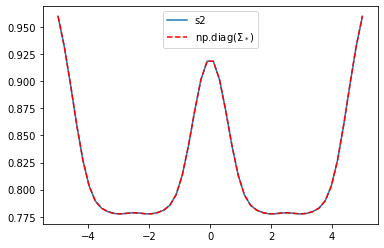

In [11]:
pl.plot(Xtest, s2, label = "s2")
pl.plot(Xtest, np.diag(K_ss + 1e-6*np.eye(n) - np.dot(v.T, v)), 'r--', label = "np.diag($\Sigma_*$)")
pl.legend()
pl.show()

It turned out that the `s2` vector (variance vector) is equal to the `np.diag(K_ss + 1e-6*np.eye(n) - np.dot(v.T, v))`, or the diagonal entries of the $\Sigma_*$. Maybe the `s2` was calculated differently in the code due to numerical efficienty or stability...

## 4. Estimating kernel parameters (hyperparameters in GPR)

## 5. References  

1. https://katbailey.github.io/post/gaussian-processes-for-dummies/  
2. https://gitlab.com/youtube-optimization-geeks/uncertainty-quantification;  
   https://www.youtube.com/watch?v=JXdrq7--XV0  
3. Nano de Freitas's lecture slide:  
   https://www.cs.ubc.ca/~nando/540-2013/lectures.html;  
   https://www.youtube.com/watch?v=4vGiHC35j9s&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=8;
4. KPM book